In [227]:
import pandas as pd
import xgboost as xgb
from collections import Counter
from sklearn.impute import SimpleImputer
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import graphviz
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

In [195]:
class Selector(BaseEstimator, TransformerMixin):
    
    """
    custom transformer that returns a column called col_name from data frame X as a Series
    """

    def __init__(self, col_name):
        self.col_name = col_name 
      
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        return X[self.col_name]
    
class ToFloat(BaseEstimator, TransformerMixin):
    
    """
    custom transformer that returns a column called col_name from data frame X as a Series
    """

    def __init__(self):
        pass
      
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        return X.apply(lambda x: float(str(x)) if str(x).strip() else -1) \
                            .values.reshape(-1,1)
        
    
class GetDummies(BaseEstimator, TransformerMixin):
    
    """
    introduce new binary variables via one-hot-encoding
    """

    def __init__(self, cols_to_encode):
        self.cols_to_encode = cols_to_encode 
      
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        return pd.get_dummies(X[self.cols_to_encode], columns=self.cols_to_encode)
    
    def get_feature_names(self):
        return X.columns.tolist()

In [196]:
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

In [197]:
data.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [198]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
target = ['Churn']
cat_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']
cat_features_processed = ['SeniorCitizen']

In [199]:
preprocessing = FeatureUnion([('dummies', GetDummies(cols_to_encode=cat_features)),
                              ('fixed_numerical', Pipeline([('select', Selector('TotalCharges')),
                                                            ('to_float', ToFloat()),
                                                            ('impute', SimpleImputer(missing_values=-1, strategy='mean'))])),
                              ('original_numerical', Selector(['tenure', 'MonthlyCharges', 'SeniorCitizen']))
                             ])

In [208]:
X = preprocessing.fit_transform(data)

In [216]:
y = data[target]['Churn'].apply(lambda x: 1 if x == "Yes" else 0 if x == 'No' else None).values

### Feature Selection
We are going to pick the best original features by applying a statistical test. We will also apply a dimensionality reduction method to be able to make use of the reduced feautes.

In [217]:
# best k features based on univariate statistical tests
best_original_features = SelectKBest(score_func=chi2, k=4)
# reduce dimensionality to n_components components that will make the new features
pca = PCA(n_components=4)
# combine the above old and new features into a feature union
combined_features = FeatureUnion([("pca_components", pca), 
                                  ("best_original_feats", best_original_features)])

### Classifier
We use the Random Forests classifier for starters.

In [218]:
classifier = RandomForestClassifier(n_estimators=100)

### Pipeline
Now we put together a pipeline to do grid search.

In [219]:
pipeline = Pipeline([('features', combined_features), 
                     ('classifier', classifier)])

### Parameter Grid for grid search

In [220]:
param_grid = dict(features__pca_components__n_components=[4,6,8,10],
                  features__best_original_feats__k=[2,4,6,8],
                  classifier__n_estimators=[100,200])

### Grid Search

In [222]:
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=5)

In [223]:
# fit now
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4, score=0.7608232789212207, total=   0.8s
[CV] classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4, score=0.7806955287437899, total=   0.8s
[CV] classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4, score=0.7615330021291696, total=   0.8s
[CV] classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


[CV]  classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4, score=0.7842441447835344, total=   0.8s
[CV] classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


[CV]  classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=4, score=0.7782515991471215, total=   0.8s
[CV] classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=6 
[CV]  classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=6, score=0.7970191625266146, total=   0.8s
[CV] classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=6 
[CV]  classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=6, score=0.7984386089425124, total=   0.8s
[CV] classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=6 
[CV]  classifier__n_estimators=100, features__best_original_feats__k=2, features__pca_components__n_components=6, score=0.772888573456352, total=   0.8s
[CV] classifier__n_estimators=100, features__b

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.8min finished


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('pca_components', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('best_original_feats', SelectKBest(k=8, score_func=<function chi2 at 0x128e94510>))],
   ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4232)

In [226]:
y_pred = grid_search.predict(X_test)

In [228]:
accuracy_score(y_test, y_pred)

0.9947941315664931

In [229]:
# set up a warning filter to suppress annoying future warnings
with warnings.catch_warnings():
    
    warnings.filterwarnings('ignore',category=FutureWarning)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    
    num_round = 16
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=3)
    
    bst.dump_model(fout='dump.raw.json', dump_format='json')

[0]	eval-auc:0.793749	train-auc:0.78886
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 3 rounds.
[1]	eval-auc:0.828415	train-auc:0.825413
[2]	eval-auc:0.834881	train-auc:0.833907
[3]	eval-auc:0.83703	train-auc:0.840716
[4]	eval-auc:0.841446	train-auc:0.845377
[5]	eval-auc:0.842991	train-auc:0.850008
[6]	eval-auc:0.840912	train-auc:0.851972
[7]	eval-auc:0.839741	train-auc:0.853403
[8]	eval-auc:0.840938	train-auc:0.85542
[9]	eval-auc:0.84117	train-auc:0.857284
[10]	eval-auc:0.841492	train-auc:0.85833
[11]	eval-auc:0.843172	train-auc:0.859596
[12]	eval-auc:0.843012	train-auc:0.860528
[13]	eval-auc:0.840828	train-auc:0.8619
[14]	eval-auc:0.840358	train-auc:0.862554
[15]	eval-auc:0.840057	train-auc:0.863628


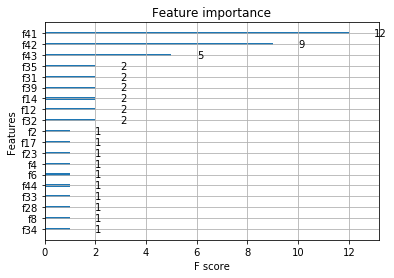

In [230]:
xgb.plot_importance(bst)